## Example from [scikit-image plot-label](https://scikit-image.org/docs/dev/auto_examples/segmentation/plot_label.html)

- define data

In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from skimage import data
from skimage.filters import threshold_otsu
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops
from skimage.morphology import closing, square
from skimage.color import label2rgb
from skimage.transform import resize


image = data.coins()[50:-50, 50:-50]
image = resize(image, (256, 256))

# apply threshold
thresh = threshold_otsu(image)
bw = closing(image > thresh, square(3))

# remove artifacts connected to image border
cleared = clear_border(bw)

## Running scikit-image

In [2]:
# label image regions
label_image = label(cleared.copy())
# to make the background transparent, pass the value of `bg_label`,
# and leave `bg_color` as `None` and `kind` as `overlay`
image_label_overlay = label2rgb(label_image, image=image, bg_label=0)

## Running cc_torch

In [3]:
import torch
from cc_torch import get_connected_components

cleared_torch = torch.from_numpy(cleared.copy()).to("cuda", torch.uint8)

cleared_torch_stack = torch.stack(
    [cleared_torch, cleared_torch.flip(dims=[-1]), cleared_torch.flip(dims=[-2])], dim=0
).unsqueeze(1)
cc_out_cuda, counts_cuda = get_connected_components(cleared_torch_stack, get_counts=True)
cc_out = cc_out_cuda[0, 0].cpu().numpy()

cc_image_overlay = label2rgb(cc_out, image=image, bg_label=0)

## Plot

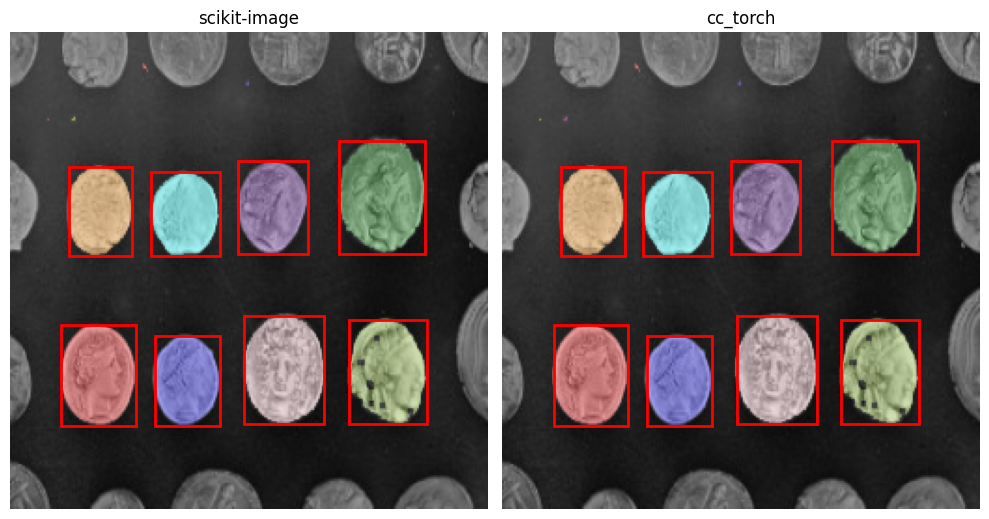

In [4]:
fig, axes = plt.subplots(1, 2, figsize=(10, 6))

def show_ax(ax, title, image, label):
    ax.set_title(title)
    ax.imshow(image)

    for region in regionprops(label):
        # take regions with large enough areas
        if region.area >= 100:
            # draw rectangle around segmented coins
            minr, minc, maxr, maxc = region.bbox
            rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                      fill=False, edgecolor='red', linewidth=2)
            ax.add_patch(rect)

    ax.set_axis_off()

show_ax(axes[0], "scikit-image", image_label_overlay, label_image)
show_ax(axes[1], "cc_torch", cc_image_overlay, cc_out)
plt.tight_layout()
plt.show()

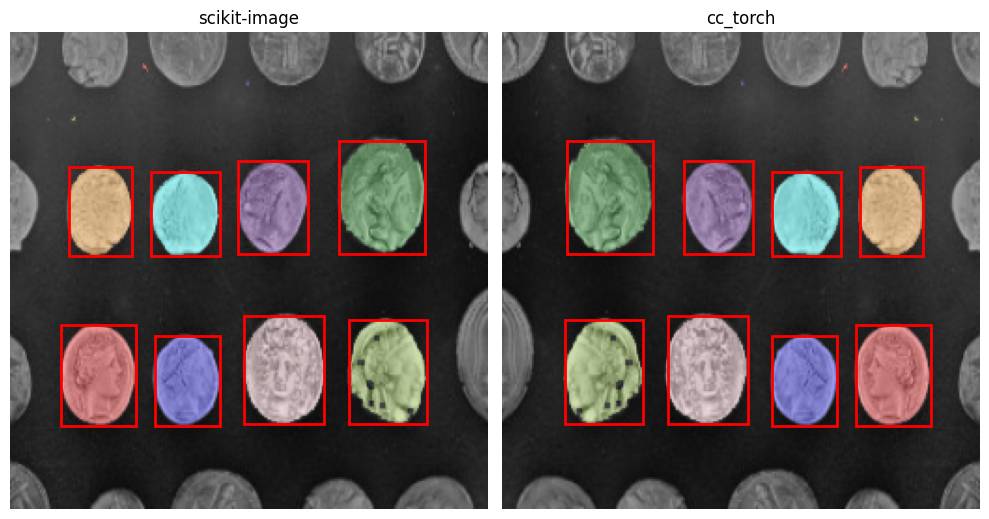

In [5]:
image = image[:, ::-1]
cc_out = cc_out_cuda[1, 0].cpu().numpy()
cc_image_overlay = label2rgb(cc_out, image, bg_label=0)

fig, axes = plt.subplots(1, 2, figsize=(10, 6))

def show_ax(ax, title, image, label):
    ax.set_title(title)
    ax.imshow(image)

    for region in regionprops(label):
        # take regions with large enough areas
        if region.area >= 100:
            # draw rectangle around segmented coins
            minr, minc, maxr, maxc = region.bbox
            rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                      fill=False, edgecolor='red', linewidth=2)
            ax.add_patch(rect)

    ax.set_axis_off()

show_ax(axes[0], "scikit-image", image_label_overlay, label_image)
show_ax(axes[1], "cc_torch", cc_image_overlay, cc_out)
plt.tight_layout()
plt.show()

In [6]:
for n in range(cc_out_cuda.size(0)):
    areas = []
    for v in torch.unique(cc_out_cuda[n]).tolist():
        if v == 0:
            continue
        area = torch.sum(cc_out_cuda[n] == v).item()
        areas.append(area)
    
    areas.sort()
    print(f"n={n}")
    print(areas)
    print(torch.unique(counts_cuda[n]).tolist())

n=0
[1, 3, 3, 7, 1253, 1285, 1315, 1388, 1663, 1685, 1962, 2170]
[0, 1, 3, 7, 1253, 1285, 1315, 1388, 1663, 1685, 1962, 2170]
n=1
[1, 3, 3, 7, 1253, 1285, 1315, 1388, 1663, 1685, 1962, 2170]
[0, 1, 3, 7, 1253, 1285, 1315, 1388, 1663, 1685, 1962, 2170]
n=2
[1, 3, 3, 7, 1253, 1285, 1315, 1388, 1663, 1685, 1962, 2170]
[0, 1, 3, 7, 1253, 1285, 1315, 1388, 1663, 1685, 1962, 2170]
